<h1>Self-Driving Agent Report</h1>

<h2>1. Implementation of a Basic Driving Agent</h2>

As starting task, we will move the smartcab around the environment using a random approach. The set of possible actions will be: None, forward, left, right. The deadline will be set to false, but this doesn't mean that smartcab has an infinite number of moves as can see on code of the file **smartcab/environment.py** (but will increase a lot the number of moves available).

The code corresponding to this agent can be found on the class **RandomAgent** at the file **smartcab/agents.py**.

Observations from simulation:

1. Normally the smartcab action is not optimal, but normally reaches the destination because has a lot of moves available to reach the destination.
2. The environment  doesn't allow any agent to execute and action that violates traffic rules, but a strong negative reward is applied.

<h2>2. Inform the Driving Agent</h2>

The next task  is to identify a set of states that are appropriate for modeling the smartcab and environment. 

All the information we receive come from the environment and the planner.

Sensing the environment provide us with these inputs:

- light:
    - Possible values: Red / Green
- oncoming:
    - Possible values: None / Forward / Right / Left
    - Indicates if there is a car oncoming and the action wants to execute.
- right:
    - Possible values: None / Forward / Right / Left
    - Indicates if there is a car approaching from the right oncoming and 
    the action wants to execute.
- left:
    - Possible values: None / Forward / Right / Left
    - Indicates if there is a car approaching from the left oncoming and 
    the action wants to execute.

Also from the environment we can obtain the deadline, that is the number of remaining moves to reach the destination.

The planner provides next_waypoint, with these possible values: Forward, Right and Left.

For representing the state we will use: **next_waypoint**, **light**, **oncoming**, **right** and **left**.

Having in mind we use *next_waypoint*, is not very useful to also use *deadline*. Also *deadline* will increase considerably the number of possible states, and would penalize the Q-Learning implementation.

The information from *light*, *oncoming*, *right* and *left* can help Q-Learning to avoid traffic violations. The information from *next_waypoint* can help Q-Learning to reach the destination as soon as possible.
 
Having in mind the properties used for the state, and possible values for each of these, the total number of different states are: 3 x 2 x 4 x 4 x 4. This means a total of 384 states at a given time.

<h2>3. Implement a Q-Learning Driving Agent</h2>

The third task is to implement the Q-Learning algorithm for the driving agent. The code corresponding to this agent can be found on the class **QLearningAgent** at the file **smartcab/agents.py**.

The core of the algorithm is a simple value iteration update. It assumes the old value and makes a correction based on the new information (Source: [Wikipedia](https://en.wikipedia.org/wiki/Q-learning)):

![](images/qlearn.png)

Before proceeding to the simulation, some parameter values should be set.

In the formula shown above, two contants can be seen:
- **alpha_rate (α)** or **learning rate**: Determines to what extent the newly acquired information will override the old information.
- **gamma rate (γ)** or **discount factor**: Determines the importance of future rewards.

Another important parameter when *QLearnAgent* should choose an action is the **epsilon_rate (ε)** or **exploration rate**. This parameter determines when to explore new states, or when to exploit already learn information.

Finally another important value is the **Q init-value**, that is the value assigned to initialize the *Q matrix*. Please, notice that in the I don't make a static initialization. Instead, in the method **get_q_value** I return **self.q_init_value**:

~~~~
def get_q_value(self, state, action):
    key = (state, action)
    return self.q_matrix.get(key, self.q_init_value)
~~~~

The param **self.q_init_value** can be set on the parameters of the *QLearnAgent* constructor.

In my first attempt I will try with a very *exploratory* *QLearnAgent*. I will assign these values: *alpha_rate = 0.7*, *gamma rate = 0.5*, *epsilon_rate = 0.9* and *Q init-value = 10*.

The simulation will be executed 100 times, with enforce_deadline to True. Some code has been create to generate stats that I will analyze.

<h4>3.1. Analysis of generated data</h4>

In [32]:
import pandas as pd

data_q_first = pd.read_csv("smartcab/main_q-agent_first_stats.csv", index_col=0)

The generated stats consist on a table containing 100 rows (one by simulation round), and 6 columns:
- **simulation_round**: The round number of the simulation.
- **success**: True if the agent reached the destination.
- **cum_reward**: The accumulated reward in that simulation.
- **explored_states_cum**: The accumulated number of states explored.
- **traffic_violations_count**: The traffic violations that occurred in that simulation.
- **actions_count**: The actions taken in that simulation.

Let's explore the 10 first rounds:

In [35]:
data_q_first.head(10)

,simulation_round,success,cum_reward,explored_states_cum,traffic_violations_count,actions_count
0,1,True,-6.5,10,5,16
1,2,True,3.5,21,5,16
2,3,False,-9.0,29,7,30
3,4,False,4.5,31,5,20
4,5,False,-9.5,31,12,35
5,6,False,3.5,31,8,30
6,7,False,-2.5,32,7,25
7,8,False,-11.0,35,8,40
8,9,False,-3.5,36,7,25
9,10,False,-5.0,39,10,25


We see that normally doesn't have success and commits a lot of traffic violations. The accumulated reward is normally negative. The explored states increases as rounds are done.

Let's see now the 10 last iterations:

In [36]:
data_q_first.tail(10)

,simulation_round,success,cum_reward,explored_states_cum,traffic_violations_count,actions_count
90,91,False,2.0,110,7,20
91,92,False,-4.5,110,9,25
92,93,False,1.0,111,6,30
93,94,False,0.5,111,5,20
94,95,False,-4.0,111,5,20
95,96,False,-2.0,112,7,20
96,97,True,7.0,112,6,24
97,98,False,-7.5,112,12,40
98,99,False,10.5,112,3,20
99,100,False,-12.5,112,10,30


We see more or less the same behaviour that in the first rounds, but is exploring many new states.

I didn't notice many changes with respect to the *RandomAgent*. The *exploratory nature* of our *QLearnAgent* causes that his behaviour in the first 100 rounds is more or less the same that the *RandomAgent*.

<h2>4. Improve the Q-Learning Driving Agent</h2>

Now let's tune the values for the **Q init value**, the **learning rate (alpha)**, **the discount factor (gamma)** and the **exploration rate (epsilon)**.

I will use *Grid Search* technique to tune these parameters.

<h3>4.1. Grid Search</h3>

I will do a *Grid Search* with these range of values:
- *q_init_values*: 0.0, 5.0, 10 (3 values)
- *alpha_rate*: 0.00, 0.25, 0.50, 0.75, 1.00 (5 values)
- *epsilon_rate*: 0.00, 0.25, 0.50, 0.75, 1.00 (5 values)
- *gamma_rate*: 0.00, 0.25, 0.50, 0.75, 1.00 (5 values)

The total of combinations will be 375 (3x5x5x5). For each of the combinations, 100 simulations will be performed. This means 37.500 simulations will be done.

For each combination of parameters we will aggregatte **ONLY** the results from the last 10 simulations of the *QLearningAgent*. These aggregated stats will be stored on a csv file, that we will analyze.

The correspoding code to do the *Grid Search* and to generate the aggreggated stats can be found on **smartcab/main_qlearn_agent_tuning.py**.

In [2]:
import pandas as pd

tuning_data = pd.read_csv("smartcab/qlearn_agent_tuning_results_3_samples.csv", index_col=0)

Let's see some sample rows to understand the data contained:

In [3]:
tuning_data.head(5)

,q_init_value,alpha_rate,epsilon_rate,gamma_rate,success_perc,traffic_violations_avg,explored_states_avg,reward_cum_avg,actions_avg
0,0.0,0.0,0.0,0.0,30.0,7.2,120.0,-2.15,27.4
1,0.0,0.0,0.0,0.5,20.0,6.4,86.8,-0.05,27.5
2,0.0,0.0,0.0,1.0,20.0,8.4,104.6,-2.15,26.8
3,0.0,0.0,0.5,0.0,10.0,10.0,109.2,-7.00,27.1
4,0.0,0.0,0.5,0.5,10.0,6.6,87.8,0.05,23.7


Each row corresponds to a simulation. The columns are:
- **q_init_value**: The Q initial value used in that simulation.
- **alpha_rate**: The alpha rate value used in that simulation.
- **epsilon_rate**: The epsilon rate value used in that simulation.
- **gamma_rate**: The gamma rate value used in that simulation.
- **success_perc**: The percentage of success in that simulation (only for 10 last simulations done).
- **traffic_violations_avg**: The traffic violation on average in that simulation (only for 10 last simulations done).
- **explored_states_avg**: The explored states on average in that simulation (only for 10 last simulations done).
- **reward_cum_avg**: The accumulated reward on average in that simulation (only for 10 last simulations done).
- **actions_avg**: The actions done on average in that simulation (only for 10 last simulations done).

<h3>4.2. An optimal policy</h3>

Before looking for the optimal combination of parameters, we should define an optimal policy for the *QLearnAgent*.

In my opinion an optimal policy for the smartcab is one that (in order of importance):
1. Minimizes the number of traffic violations.
2. Maximizes the success.

We can also consider in the policy that the number of actions taken is the less as possible.

<h3>4.3. Looking for the best combination of parameters</h3>

Let's start describing the data in the generated stats:

In [4]:
tuning_data.describe()

,q_init_value,alpha_rate,epsilon_rate,gamma_rate,success_perc,traffic_violations_avg,explored_states_avg,reward_cum_avg,actions_avg
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,5.000000,0.500000,0.500000,0.500000,20.617284,6.454321,96.527160,-1.064815,26.695062
std,4.107919,0.410792,0.410792,0.410792,19.896336,3.013928,11.978178,4.228559,4.466428
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.100000,-11.300000,6.600000
25%,0.000000,0.000000,0.000000,0.000000,10.000000,6.100000,88.200000,-3.350000,24.000000
50%,5.000000,0.500000,0.500000,0.500000,20.000000,7.300000,96.800000,-1.850000,27.500000
75%,10.000000,1.000000,1.000000,1.000000,20.000000,8.600000,105.600000,-0.050000,29.500000
max,10.000000,1.000000,1.000000,1.000000,100.000000,11.100000,120.000000,12.550000,36.500000


The minimum *traffic_violations_avg* is 0.0, the maximum for *success_perc* is 100% and the minimum for *actions_avg* is 6.6.

Let's look for rows where *traffic_violations_avg <= 1* and *success_perc >= 90*:

In [7]:
tuning_data_rows = tuning_data[(tuning_data['traffic_violations_avg'] <= 1) & (tuning_data['success_perc'] >= 90)]
tuning_data_rows.head()

,q_init_value,alpha_rate,epsilon_rate,gamma_rate,success_perc,traffic_violations_avg,explored_states_avg,reward_cum_avg,actions_avg
10,0.0,0.5,0.0,0.5,100.0,0.1,67.9,10.8,13.6


In the row 10 we can see that in the 10 last simulations done, the **success_perc=100** and **traffic_violations_avg=0.1**. We can also see that **actions_avg=13.6**.

It seems that the price to pay for minimize *traffic_violations_avg* is being far from the minimum *actions_avg* for all combinations trid.

So based in my criteria for an optimal policy, the parameter values to use are:
- *q_init_value* = 0.0
- *alpha_rate* = 0.5
- *epsilon_rate* = 0.0
- *gamma rate* = 0.5

<h3>4.4. How these combination of parameters influence QLearnAgent behaviour</h3>

To proceed to the analysis, let's generate detailed stats for a *QLearnAgent* using these values for parameters.

In **smartcab/main_qlearn_agent_tuned.py** we execute 100 simulations and store the stats on a cvs file:

In [9]:
stats_tuned = pd.read_csv("smartcab/stats_tuned_qlearn_agent.csv", index_col=0)

The *epsilon_rate=0.0* determines that the *QLearningAgent* will always try to exploit what he has already learn. Also a *q_init_value = 0.0* means that the *QLearningAgent* will be very conservative from the very beginning. 

The combination of these two parameters determines that the *QLearningAgent* will leave soon to explore new states. Let's visualize this behaviour:

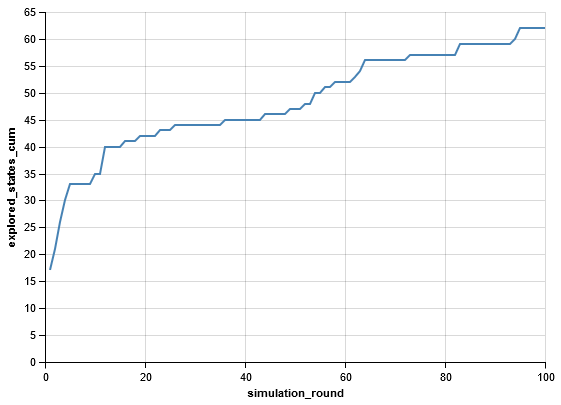

In [22]:
from altair import Chart

Chart(stats_tuned).mark_line().encode(
    x= 'simulation_round',
    y='explored_states_cum'
)

As expected abount round 10 onwards the number of explored states increses much slower that at the initial rounds. It seems that explored will stabilize around 60-65, but a test with more than 100 round simulations is needed to confirm this trend.

Other important aspect is the the number of possible locations for the smartcab:

![](images/grid.png)

There are 48 possible locations (8 x 6 grid). In the simulation there are 4 smartcabs in total.

This means that there are very few chances for our *QLearnAgent* to learn situations where the actions taken by the other cars are important to avoid traffic violations. So it will need many simulations to fully learn to avoid traffic violations, because will have few chances to learn correctly interact with other agents.

Let's visualize the correlation between *simulation_rounds* and *traffic_violations_count*:

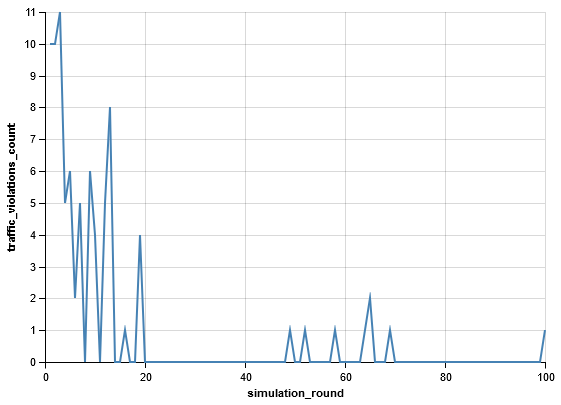

In [23]:
from altair import Chart

Chart(stats_tuned).mark_line().encode(
    x= 'simulation_round',
    y= 'traffic_violations_count'
)

As expected we can see that about round 60, the *QLearnAgent* still incurs on some traffic violations.

The *alpha_rate=0.5* determines that the new learned value will influence on half of his value the old value. 

<h4>4.4.1. Analysis of first steps of q-learning agent</h4>

[TODO]

<h4>4.4.2. Analysis of the last steps of q-learning agent</h4>

[TODO]

<h3>5. n=300</h3>

I suspect that with a larger number of simulations (more chances to learn), a **more exploratory** *QLearnerAgent* will perform better than our previous **conservative** agent.

The reason is, that as stated previously, is difficult for the agent to interact with other agents. With only 100 simulations, the more conservative agent will get better 

In [24]:
grid_n_300 = pd.read_csv("smartcab/qlearn_agent_tuning_n300.csv", index_col=0)

In [26]:
grid_n_300_subset = grid_n_300[(grid_n_300['traffic_violations_avg'] <= 1) & (grid_n_300['success_perc'] >= 90)]
grid_n_300_subset.head()

,q_init_value,alpha_rate,epsilon_rate,gamma_rate,success_perc,traffic_violations_avg,explored_states_avg,reward_cum_avg,actions_avg
36,5.0,0.5,0.0,0.0,100.0,0.1,182.5,12.30,14.5
37,5.0,0.5,0.0,0.5,100.0,0.2,127.8,9.55,11.8
